In [2]:
# IMPORT NECESSARY LIBRARIES
from tensorflow.keras.models import load_model
import librosa
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio
import numpy as np
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import IPython.display as ipd  # To play sound in the notebook
import os # interface with underlying OS that python is running on
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization, Dense
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [2]:
augmented_root = './datasets/augmented'
padding_root = './datasets/padding'

In [3]:
# CREATE FUNCTION TO EXTRACT EMOTION LABEL
emotion = []
file_path = []

def get_emotion_path_list(root):
    emotion_list = []
    path_list = []
    for path, subdirs, files in os.walk(root):
        for name in files:
            if name.endswith(".wav"):
                # print(path.split("/")[2]) # label
                emotion_list.append(path.split("/")[3])
                path_list.append(os.path.join(path, name))
    return emotion_list, path_list

In [4]:
emotion, file_path = get_emotion_path_list(padding_root)

In [5]:
# PUT EXTRACTED LABELS WITH FILEPATH INTO DATAFRAME
padding_audio_df = pd.DataFrame(emotion)
padding_audio_df.columns = ['labels']
padding_audio_df = pd.concat([padding_audio_df, pd.DataFrame(file_path, columns = ['path'])], axis=1)
padding_audio_df.head()

,labels,path
0,taunt,./datasets/padding/taunt/padding_re-threat-57.wav
1,taunt,./datasets/padding/taunt/padding_re-threat-43.wav
2,taunt,./datasets/padding/taunt/padding_re-threat-80.wav
3,taunt,./datasets/padding/taunt/padding_re-threat-81.wav
4,taunt,./datasets/padding/taunt/padding_re-threat-42.wav


In [6]:
emotion, file_path = get_emotion_path_list(augmented_root)

In [7]:
# PUT EXTRACTED LABELS WITH FILEPATH INTO DATAFRAME
augmented_audio_df = pd.DataFrame(emotion)
augmented_audio_df.columns = ['labels']
augmented_audio_df = pd.concat([augmented_audio_df, pd.DataFrame(file_path, columns = ['path'])], axis=1)
augmented_audio_df.head()

,labels,path
0,taunt,./datasets/augmented/taunt/data_noise01_paddin...
1,taunt,./datasets/augmented/taunt/data_speed08_paddin...
2,taunt,./datasets/augmented/taunt/data_speed08_paddin...
3,taunt,./datasets/augmented/taunt/data_speed09_paddin...
4,taunt,./datasets/augmented/taunt/data_speed09_paddin...


In [8]:
audio_df = pd.concat([padding_audio_df, augmented_audio_df], axis=0, ignore_index=True )
audio_df

,labels,path
0,taunt,./datasets/padding/taunt/padding_re-threat-57.wav
1,taunt,./datasets/padding/taunt/padding_re-threat-43.wav
2,taunt,./datasets/padding/taunt/padding_re-threat-80.wav
3,taunt,./datasets/padding/taunt/padding_re-threat-81.wav
4,taunt,./datasets/padding/taunt/padding_re-threat-42.wav
...,...,...
15730,upset,./datasets/augmented/upset/data_pitch12_paddin...
15731,upset,./datasets/augmented/upset/data_speed12_paddin...
15732,upset,./datasets/augmented/upset/data_shift32_paddin...
15733,upset,./datasets/augmented/upset/data_noise01_paddin...


In [9]:
print(len(audio_df[audio_df.labels == 'taunt']))
print(len(audio_df[audio_df.labels == 'upset']))
print(len(audio_df[audio_df.labels == 'angry']))
print(len(audio_df[audio_df.labels == 'calm']))

1770
1470
5160
7335


In [10]:
# ENSURE COLUMN VALUES ARE CORRECT
pd.set_option('display.max_colwidth', -1)
audio_df.sample(10)

,labels,path
2474,taunt,./datasets/augmented/taunt/data_noise05_padding_re-threat-20.wav
14713,upset,./datasets/augmented/upset/data_shift16_padding_為什麼老師要罵我.wav
7991,calm,./datasets/augmented/calm/data_speed12_padding_re-praise-34.wav
11613,angry,./datasets/augmented/angry/data_speed09_padding_zt1-angry-36.wav
2954,calm,./datasets/augmented/calm/data_speed11_padding_z1-normal-21.wav
2525,taunt,./datasets/augmented/taunt/data_speed11_padding_re-threat-67.wav
9157,calm,./datasets/augmented/calm/data_pitch11_padding_nnn-normal-3.wav
6311,calm,./datasets/augmented/calm/data_speed12_padding_z1-normal-30.wav
15489,upset,./datasets/augmented/upset/data_speed08_padding_re-cry- (11).wav
10443,angry,./datasets/augmented/angry/data_speed11_padding_re-angry-14.wav


<AxesSubplot:>

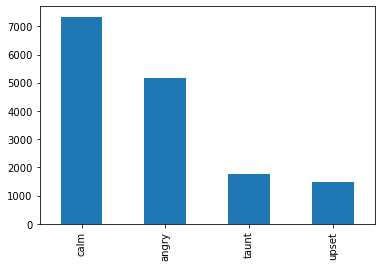

In [11]:
# LOOK AT DISTRIBUTION OF CLASSES
audio_df.labels.value_counts().plot(kind='bar')

In [12]:
# ITERATE OVER ALL AUDIO FILES AND EXTRACT LOG MEL SPECTROGRAM MEAN VALUES INTO DF FOR MODELING 
df = pd.DataFrame(columns=['features'])

counter=0

for index, path in enumerate(audio_df.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast', duration=10.0, sr=None)
    
    stft = np.abs(librosa.stft(X))

    # fmin 和 fmax 對應於人類語音的最小最大基本頻率
    pitches, magnitudes = librosa.piptrack(X, sr=sample_rate, S=stft, fmin=70, fmax=400)
    pitch = []
    for i in range(magnitudes.shape[1]):
        index = magnitudes[:, 1].argmax()
        pitch.append(pitches[index, i])

    pitch_tuning_offset = librosa.pitch_tuning(pitches)
    pitchmean = np.mean(pitch)
    pitchstd = np.std(pitch)
    pitchmax = np.max(pitch)
    pitchmin = np.min(pitch)

    # 頻譜質心
    cent = librosa.feature.spectral_centroid(y=X, sr=sample_rate)
    cent = cent / np.sum(cent)
    meancent = np.mean(cent)
    stdcent = np.std(cent)
    maxcent = np.max(cent)

    # 譜平面
    flatness = np.mean(librosa.feature.spectral_flatness(y=X))

    # 使用系數為13的MFCC特徵
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13).T, axis=0)
    mfccsstd = np.std(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13).T, axis=0)
    mfccmax = np.max(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13).T, axis=0)

    # 色譜圖
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)

    # 梅爾頻率
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T, axis=0)

    # ottava對比
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T, axis=0)

    # 過零率
    zerocr = np.mean(librosa.feature.zero_crossing_rate(X))

    S, phase = librosa.magphase(stft)
    meanMagnitude = np.mean(S)
    stdMagnitude = np.std(S)
    maxMagnitude = np.max(S)

    # 均方根能量
    rms = librosa.feature.rms(S=S)[0]
    meanrms = np.mean(rms)
    stdrms = np.std(rms)
    maxrms = np.max(rms)

    ext_features = np.array([
        flatness, zerocr, meanMagnitude, maxMagnitude, meancent, stdcent,
        maxcent, stdMagnitude, pitchmean, pitchmax, pitchstd,
        pitch_tuning_offset, meanrms, maxrms, stdrms
    ])

    ext_features = np.concatenate((ext_features, mfccs, mfccsstd, mfccmax, chroma, mel, contrast))
        
    df.loc[counter] = [ext_features]
    counter=counter+1   

print(len(df))
df.head()

15735


,features
0,"[0.3496195077896118, 0.129026370307508, 0.554053544998169, 163.03797912597656, 0.0031948881789137388, 0.0029217072102637005, 0.011337591103739907, 2.890937566757202, 21.75051498413086, 120.07567596435547, 45.61146545410156, 0.45000000000000007, 0.03477180153402467, 0.2391733214998206, 0.055005978355567184, -367.203125, 22.409263610839844, -12.061744689941406, 11.041152000427246, -22.576000213623047, 1.8775392770767212, -8.535937309265137, -9.247295379638672, -2.8386306762695312, -5.565779209136963, -4.472590923309326, -3.5288166999816895, -1.5168635845184326, 171.079345703125, 44.82072448730469, 52.17595672607422, 25.972267150878906, 36.737483978271484, 11.954723358154297, 15.739465713500977, 15.130620956420898, 11.039962768554688, 9.662431716918945, 8.60898208618164, 8.905916213989258, 7.6531453132629395, 25.65533447265625, 136.48431396484375, 82.37645721435547, 113.67911529541016, 37.55311584472656, 42.78006362915039, 36.130760192871094, 20.368812561035156, 20.902780532836914, 18.12950897216797, 32.54488754272461, 16.07016944885254, 27.766477584838867, 0.36930540204048157, 0.35314276814460754, 0.3384576737880707, 0.326745867729187, 0.3393385112285614, 0.33886340260505676, 0.368495911359787, 0.4080461263656616, 0.4625314474105835, 0.4755983054637909, 0.45846739411354065, 0.4156898856163025, 0.027579978108406067, 0.01393063273280859, 0.007552608381956816, 0.004306493327021599, 0.006882698740810156, 0.0060134283266961575, 0.0100211501121521, 0.21985389292240143, 0.6093171834945679, 0.9432745575904846, 1.8959730863571167, 2.1388020515441895, 3.74784517288208, 7.740479946136475, 1.670241117477417, 0.6651673316955566, 3.6480600833892822, 5.79976749420166, 4.700876235961914, 4.1018967628479, 3.9417903423309326, 3.4115519523620605, 4.072484493255615, 9.763460159301758, 8.762375831604004, 3.0331830978393555, 2.000221014022827, 10.269196510314941, 11.350957870483398, 4.024000644683838, 3.521454334259033, 4.365978717803955, 4.920716762542725, 5.979846954345703, ...]"
1,"[0.4200870394706726, 0.06824393470447285, 0.5609909296035767, 167.6558380126953, 0.0031948881789137375, 0.0028470788738964407, 0.01133117069887162, 2.83953857421875, 7.450558662414551, 97.6470947265625, 25.293689727783203, -0.28, 0.03325756035755, 0.2138799201972371, 0.05466800789958007, -353.0258483886719, 58.22929000854492, -27.58261489868164, 13.553558349609375, -4.271659851074219, -9.121867179870605, 0.8913663625717163, -4.6283135414123535, -5.005660533905029, -1.5454967021942139, -7.044949054718018, -0.8394930362701416, -4.469682693481445, 186.9652557373047, 53.03965377807617, 40.614837646484375, 18.562042236328125, 16.618980407714844, 16.63399314880371, 11.422248840332031, 10.126961708068848, 9.2562255859375, 8.138813972473145, 11.45135498046875, 5.52992582321167, 7.341512203216553, 4.560707092285156, 168.79812622070312, 27.6613712310791, 74.79946899414062, 22.71750259399414, 18.523204803466797, 27.2900447845459, 30.759033203125, 19.920042037963867, 36.2061882019043, 11.878175735473633, 15.047016143798828, 7.090427398681641, 0.3601130247116089, 0.3891226053237915, 0.3827584683895111, 0.3898226022720337, 0.38132092356681824, 0.3697682321071625, 0.37263262271881104, 0.36060914397239685, 0.35090237855911255, 0.34107550978660583, 0.36529669165611267, 0.37771478295326233, 0.004343614913523197, 0.02918022871017456, 0.054519396275281906, 0.05913833901286125, 0.05875999480485916, 0.06364371627569199, 0.3886258602142334, 0.6042848825454712, 1.370500922203064, 3.0660481452941895, 3.0807926654815674, 3.726682662963867, 4.892536163330078, 7.931325435638428, 23.70084571838379, 28.361886978149414, 10.551070213317871, 4.808716297149658, 1.0543545484542847, 0.8042829036712646, 2.2045772075653076, 3.510223865509033, 4.856097221374512, 3.489814281463623, 3.586089611053467, 6.509383678436279, 16.396835327148438, 13.923636436462402, 8.247961044311523, 7.408663272857666, 8.716965675354004, 9.167744636535645, 12.356138229370117, 8.31223201751709, ...]"
2,"[0.49863684177398

In [13]:
df_combined = pd.concat([audio_df, pd.DataFrame(df['features'].values.tolist())],axis=1)

In [14]:
df_combined = df_combined.fillna(0)

In [15]:
len(df_combined.labels)

15735

In [16]:
# DROP PATH COLUMN FOR MODELING
df_combined.drop(columns='path',inplace=True)

In [17]:
# CHECK TOP 5 ROWS
df_combined.head()

,labels,0,1,2,3,4,5,6,7,8,...,191,192,193,194,195,196,197,198,199,200
0,taunt,0.349620,0.129026,0.554054,163.037979,0.003195,0.002922,0.011338,2.890938,21.750515,...,0.024860,0.005420,0.000337,19.080706,19.134450,21.125617,19.423748,19.274803,21.902710,25.117049
1,taunt,0.420087,0.068244,0.560991,167.655838,0.003195,0.002847,0.011331,2.839539,7.450559,...,0.002620,0.000413,0.000025,17.962222,16.911051,17.674325,17.033042,16.880189,19.637548,23.111096
2,taunt,0.498637,0.081467,0.773144,273.056702,0.003195,0.003458,0.015535,5.216930,6.002203,...,0.010938,0.002382,0.000116,16.050520,19.224504,20.094982,19.420473,18.647094,21.973569,23.659706
3,taunt,0.648623,0.043919,0.402030,160.456573,0.003195,0.004484,0.017506,2.989140,7.426612,...,0.041246,0.010192,0.000410,16.558265,16.364409,16.976335,16.284359,16.494198,16.978649,20.274362
4,taunt,0.542116,0.040381,0.373848,106.289726,0.003195,0.003759,0.016790,2.185241,11.056521,...,0.017987,0.003564,0.000203,17.101434,13.360917,14.166413,14.598431,13.997962,14.618500,19.963319


In [18]:
df_combined.to_csv('features.csv', index=False)

# Prepping Data for Modeling

In [19]:
X = df_combined.iloc[:, 1:].values
Y = df_combined['labels'].values

In [20]:
encoder = OneHotEncoder()
print(np.array(Y).reshape(-1, 1))
Y = encoder.fit_transform(np.array(Y).reshape(-1, 1)).toarray()

[['taunt']
 ['taunt']
 ['taunt']
 ...
 ['upset']
 ['upset']
 ['upset']]


In [21]:
Y

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [22]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((11801, 201), (11801, 4), (3934, 201), (3934, 4))

In [23]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((11801, 201), (11801, 4), (3934, 201), (3934, 4))

In [24]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((11801, 201, 1), (11801, 4), (3934, 201, 1), (3934, 4))

In [25]:
# New model
model = Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))  # X_train.shape[1] = No. of Columns
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=4, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Metal device set to: Apple M1 Pro
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 201, 256)          1536      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 101, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 101, 256)          327936    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 51, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 51, 128)           163968    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 26, 128)           0         
_________________________________________________________________
dropout (Dropout)     

2022-04-21 21:06:57.998758: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-21 21:06:57.998860: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [26]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

2022-04-21 21:06:58.227661: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-21 21:06:58.227900: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-21 21:06:58.414775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/50
185/185 [==============================] - ETA: 0s - loss: 0.9652 - accuracy: 0.6351

2022-04-21 21:07:02.369773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


185/185 [==============================] - 5s 23ms/step - loss: 0.9652 - accuracy: 0.6351 - val_loss: 0.7508 - val_accuracy: 0.7173
Epoch 2/50
185/185 [==============================] - 4s 22ms/step - loss: 0.7046 - accuracy: 0.7228 - val_loss: 0.5779 - val_accuracy: 0.7804
Epoch 3/50
185/185 [==============================] - 4s 21ms/step - loss: 0.6062 - accuracy: 0.7604 - val_loss: 0.5081 - val_accuracy: 0.7870
Epoch 4/50
185/185 [==============================] - 4s 21ms/step - loss: 0.5162 - accuracy: 0.7934 - val_loss: 0.4583 - val_accuracy: 0.8183
Epoch 5/50
185/185 [==============================] - 4s 21ms/step - loss: 0.4537 - accuracy: 0.8220 - val_loss: 0.3715 - val_accuracy: 0.8566
Epoch 6/50
185/185 [==============================] - 4s 22ms/step - loss: 0.3937 - accuracy: 0.8456 - val_loss: 0.3398 - val_accuracy: 0.8627
Epoch 7/50
185/185 [==============================] - 4s 21ms/step - loss: 0.3466 - accuracy: 0.8669 - val_loss: 0.2959 - val_accuracy: 0.8866
Epoch 8/50

In [27]:
# Save model and weights
model_name = 'Emotion_Model.h5'
save_dir = os.path.join(os.getcwd(), 'models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("model_json_aug.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at /Users/joelai/Jupyter/資訊週專題/emotion speech recognition/models/Emotion_Model_aug.h5 


123/123 [==============================] - 1s 9ms/step - loss: 0.0471 - accuracy: 0.9850
Accuracy of our model on test data: 98.50026369094849 %


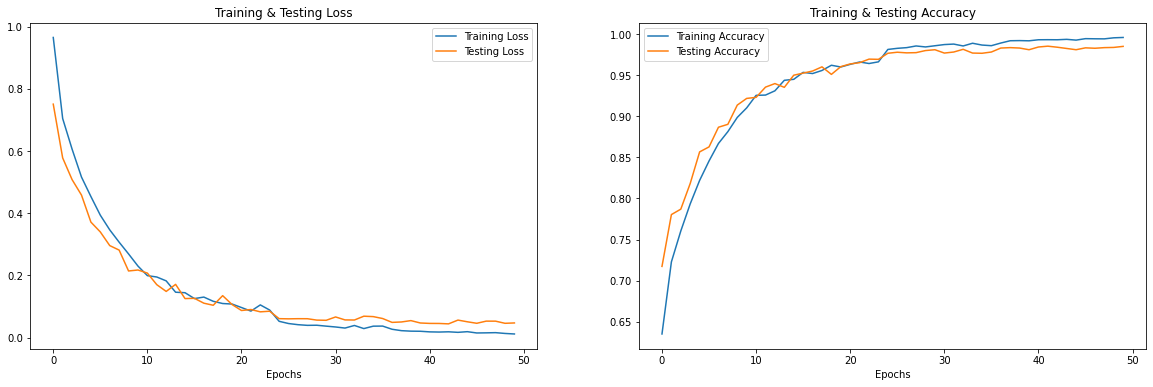

In [28]:
print("Accuracy of our model on test data:", model.evaluate(x_test, y_test)[1]*100, "%")

epochs = [i for i in range(50)]
fig, ax = plt.subplots(1, 2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20, 6)
ax[0].plot(epochs, train_loss, label = 'Training Loss')
ax[0].plot(epochs, test_loss, label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs, train_acc, label = 'Training Accuracy')
ax[1].plot(epochs, test_acc, label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")

plt.show()

In [29]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

2022-04-21 21:10:18.553191: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [33]:
pred_df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
pred_df['Predicted Labels'] = y_pred.flatten()
pred_df['Actual Labels'] = y_test.flatten()

pred_df

,Predicted Labels,Actual Labels
0,upset,upset
1,calm,calm
2,calm,calm
3,angry,angry
4,calm,calm
...,...,...
3929,angry,angry
3930,calm,calm
3931,taunt,taunt
3932,calm,calm


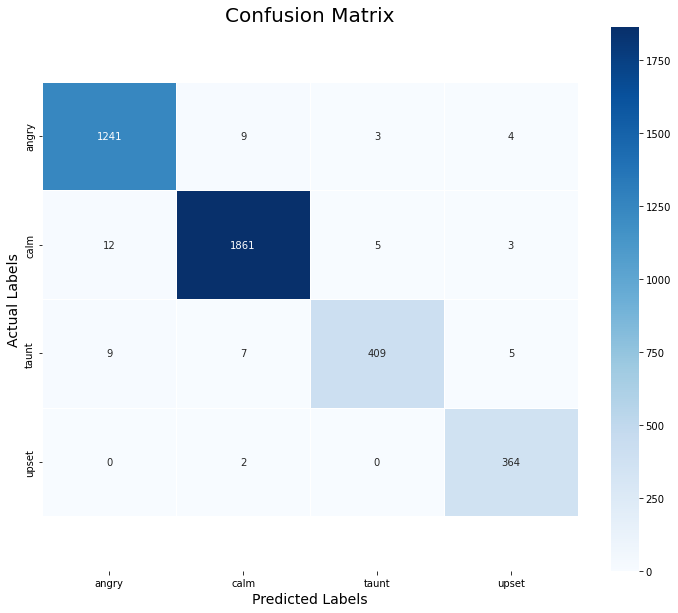

In [31]:
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION 
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig('Initial_Model_Confusion_Matrix.png')
plt.show()

In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.98      0.99      0.99      1257
        calm       0.99      0.99      0.99      1881
       taunt       0.98      0.95      0.97       430
       upset       0.97      0.99      0.98       366

    accuracy                           0.99      3934
   macro avg       0.98      0.98      0.98      3934
weighted avg       0.99      0.99      0.98      3934

